In [ ]:
# connect to google colab
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.metrics import confusion_matrix
from sklearn import metrics
#from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#Importing keras
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
np.random.seed(7)

### Colab config

In [ ]:
# COLAB CONFIG
# change colab flag to false if train using jupyter notebook
COLAB_FLAG = True
COLAB_FILEPATH = './drive/My Drive/4034-amazon-review-classification-new/' if COLAB_FLAG == True else './'
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

# Pre-processing of data for training the model (Amazon dataset)

### Import training data

In [ ]:
# using SQLite Table to read data.
con = sqlite3.connect(COLAB_FILEPATH + 'data/database.sqlite')
data_train_raw_ = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

In [ ]:
data_train_raw_.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# Filtering of the train data

### Remove duplicate entries

In [ ]:
# check duplication of an entry
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [ ]:
#Sorting data according to ProductId in ascending order
data_train_raw=data_train_raw_.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
# remove duplication of entries
data_train_raw=data_train_raw.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
data_train_raw.shape

(364173, 10)

In [ ]:
data_train_raw.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,4,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...


In [ ]:
# Checking to see how much % of data still remains
(data_train_raw['Id'].size*1.0)/(data_train_raw_['Id'].size*1.0)*100

69.25890143662969

In [ ]:
# sample query
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [ ]:
# choose data that the helpfulness numerator is higher than the denominator
data_train_raw=data_train_raw[data_train_raw.HelpfulnessNumerator<=data_train_raw.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(data_train_raw.shape)

# distribution of the score of the train data
data_train_raw['Score'].value_counts()

(364171, 10)


5    250965
4     56096
1     36307
2     20803
Name: Score, dtype: int64

### Create a training dataframe with only the comments and the ratings

In [ ]:
# create an empty dataframe
data_train = pd.DataFrame()

# to store only the required columns into the new dataframe
data_train['comments'] = data_train_raw['Text']
data_train['ratings'] = data_train_raw['Score']
data_train['type'] = "train"
data_train.head()

,comments,ratings,type
138706,this witty little book makes my son laugh at l...,5,train
138688,"I grew up reading these Sendak books, and watc...",4,train
138689,This is a fun way for children to learn their ...,4,train
138690,This is a great little book to read aloud- it ...,5,train
138691,This is a book of poetry about the months of t...,5,train


In [ ]:
data_train.shape

(364171, 3)

In [ ]:
data_train.dtypes

comments    object
ratings      int64
type        object
dtype: object

There are 364171 data that we will use to train and validate our model, now we will move on to pre-process our test data, which was scraped from trip advisor.

# Pre-processing the test set (scraped data from tripadvisor)
The goal is to clean the data of the test set so that the both datasets have the same columns

### Import test data

In [ ]:
# read the test data
data_test_raw_ = pd.read_csv(COLAB_FILEPATH+'data/trip-advisor-comments.csv')
data_test_raw_.head()

,Restaurant Name,Restaurant Type,Reviewer's Name,Rating,Comment
0,Positano @ RP,"Italian, European",aisvslife98,5,I enjoyed my time here with my girlfriends! Fa...
1,Positano @ RP,"Italian, European",Odyssey44198198885,5,Wonderful and amazing service experience. Defi...
2,Positano @ RP,"Italian, European",Ninifazelin,5,Great food and wonderful service! Will definit...
3,Positano @ RP,"Italian, European",Amaliamazlan,5,Not my first time in Positano and definitely w...
4,Positano @ RP,"Italian, European",Shahzanstim,5,Excellent service from the staff. The beef was...


In [ ]:
data_test_raw_.shape

(97190, 5)

### Filtering of the test data

In [ ]:
# remove duplication of entries
data_test_raw=data_test_raw_.drop_duplicates(subset={"Reviewer\'s Name","Rating","Comment"}, keep='first', inplace=False)
data_test_raw.shape

(88045, 5)

In [ ]:
data_test_raw.head(3)

,Restaurant Name,Restaurant Type,Reviewer's Name,Rating,Comment
0,Positano @ RP,"Italian, European",aisvslife98,5,I enjoyed my time here with my girlfriends! Fa...
1,Positano @ RP,"Italian, European",Odyssey44198198885,5,Wonderful and amazing service experience. Defi...
2,Positano @ RP,"Italian, European",Ninifazelin,5,Great food and wonderful service! Will definit...


In [ ]:
#Checking to see how much % of data still remains after removing duplications
(data_test_raw['Reviewer\'s Name'].size*1.0)/(data_test_raw_['Reviewer\'s Name'].size*1.0)*100

90.5905957403025

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(data_test_raw.shape)

# distribution of the score of the train data
data_test_raw['Rating'].value_counts()

(88045, 5)


5    46304
4    25978
3     8837
1     3464
2     3462
Name: Rating, dtype: int64

### Create a test dataframe with only the comments and the ratings

In [ ]:
# create an empty dataframe
data_test = pd.DataFrame()

# to store only the required columns into the new dataframe
data_test['comments'] = data_test_raw['Comment']
data_test['ratings'] = data_test_raw['Rating']
data_test['type'] = "test"
data_test.head()

,comments,ratings,type
0,I enjoyed my time here with my girlfriends! Fa...,5,test
1,Wonderful and amazing service experience. Defi...,5,test
2,Great food and wonderful service! Will definit...,5,test
3,Not my first time in Positano and definitely w...,5,test
4,Excellent service from the staff. The beef was...,5,test


In [ ]:
data_test.shape

(88045, 3)

In [ ]:
data_test.dtypes

comments    object
ratings      int64
type        object
dtype: object

# Merge the 2 dataframes together
Take note of the last entry of the train set and the first entry of the test set so that we can split the dataset to train-val and test set after tokenization

In [ ]:
# shape of train set
print(f'Train set dimension: {data_train.shape}')
# shape of test set
print(f'Test set dimension: {data_test.shape}')

Train set dimension: (364171, 3)
Test set dimension: (88045, 3)


In [ ]:
# merge the 2 dataframes together to perform tokenization
frames = [data_train,data_test]
data_overall = pd.concat(frames)
data_overall.head()

,comments,ratings,type
138706,this witty little book makes my son laugh at l...,5,train
138688,"I grew up reading these Sendak books, and watc...",4,train
138689,This is a fun way for children to learn their ...,4,train
138690,This is a great little book to read aloud- it ...,5,train
138691,This is a book of poetry about the months of t...,5,train


In [ ]:
# check the dimension of the merged dataframe
data_overall.shape

(452216, 3)

In [ ]:
# check the range where the data changes from train set to test set
# debug
#data_overall.iloc[:,:]
# finding the split
data_overall.iloc[364169:364173,:]

,comments,ratings,type
5259,Purchased this product at a local store in NY ...,5,train
302474,I purchased this to send to my son who's away ...,5,train
0,I enjoyed my time here with my girlfriends! Fa...,5,test
1,Wonderful and amazing service experience. Defi...,5,test


In [ ]:
# last entry of the train set
data_overall.iloc[[364170]]

,comments,ratings,type
302474,I purchased this to send to my son who's away ...,5,train


In [ ]:
# check dtypes of the merged dataframe
data_overall.dtypes

comments    object
ratings      int64
type        object
dtype: object

# Stemming and Lemmatization

In [ ]:
import re

In [ ]:
# remove contractions
def contraction_removal(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", "\n"])

In [ ]:
from bs4 import BeautifulSoup
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(data_overall['comments'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = contraction_removal(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 452216/452216 [02:00<00:00, 3743.51it/s]


In [ ]:
data_overall['comments_cleaned'] = preprocessed_reviews
data_overall.head()

,comments,ratings,type,comments_cleaned
138706,this witty little book makes my son laugh at l...,5,train,witty little book makes son laugh loud recite ...
138688,"I grew up reading these Sendak books, and watc...",4,train,grew reading sendak books watching really rosi...
138689,This is a fun way for children to learn their ...,4,train,fun way children learn months year learn poems...
138690,This is a great little book to read aloud- it ...,5,train,great little book read aloud nice rhythm well ...
138691,This is a book of poetry about the months of t...,5,train,book poetry months year goes month cute little...


In [ ]:
data_overall.shape

(452216, 4)

# Partition the rating to binary
0 <- 0,1,2  
1 <- 3,4,5


In [ ]:
def partition(x):
    if x < 3:
        return 0
    return 1

In [ ]:
actualScore = data_overall['ratings']
positiveNegative = actualScore.map(partition) 
data_overall['ratings_binary'] = positiveNegative
print("Number of data points in our data", data_overall.shape)
data_overall.head(3)

Number of data points in our data (452216, 5)


,comments,ratings,type,comments_cleaned,ratings_binary
138706,this witty little book makes my son laugh at l...,5,train,witty little book makes son laugh loud recite ...,1
138688,"I grew up reading these Sendak books, and watc...",4,train,grew reading sendak books watching really rosi...,1
138689,This is a fun way for children to learn their ...,4,train,fun way children learn months year learn poems...,1


In [ ]:
data_overall.dtypes

comments            object
ratings              int64
type                object
comments_cleaned    object
ratings_binary       int64
dtype: object

# Export cleaned corpus to csv
To save the progress of the data cleaning at this point of time

In [ ]:
data_overall.to_csv(COLAB_FILEPATH + 'data/data_overall_test_tripadvisor.csv', index=False)

# Import the cleaned corpus

In [ ]:
data_overall_ = pd.read_csv(COLAB_FILEPATH + 'data/data_overall_test_tripadvisor.csv')
data_overall_.head()

,comments,ratings,type,comments_cleaned,ratings_binary
0,this witty little book makes my son laugh at l...,5,train,witty little book makes son laugh loud recite ...,1
1,"I grew up reading these Sendak books, and watc...",4,train,grew reading sendak books watching really rosi...,1
2,This is a fun way for children to learn their ...,4,train,fun way children learn months year learn poems...,1
3,This is a great little book to read aloud- it ...,5,train,great little book read aloud nice rhythm well ...,1
4,This is a book of poetry about the months of t...,5,train,book poetry months year goes month cute little...,1


In [ ]:
data_overall_.dtypes

comments            object
ratings              int64
type                object
comments_cleaned    object
ratings_binary       int64
dtype: object

In [ ]:
# change the dtypes of object to string for some columns
#data_overall = data_overall.astype({'comments_cleaned': 'string'})

In [ ]:
data_overall_.count()

comments            452216
ratings             452216
type                452216
comments_cleaned    451235
ratings_binary      452216
dtype: int64

In [ ]:
# dropna for the row where the comments cleaned are empty
df = data_overall_.dropna()

In [ ]:
# check
df.count()

comments            451235
ratings             451235
type                451235
comments_cleaned    451235
ratings_binary      451235
dtype: int64

In [ ]:
# remove not useful columns
data_overall = df.drop(labels='comments', axis=1)
data_overall = data_overall.drop(labels='ratings', axis=1)
data_overall.head()

,type,comments_cleaned,ratings_binary
0,train,witty little book makes son laugh loud recite ...,1
1,train,grew reading sendak books watching really rosi...,1
2,train,fun way children learn months year learn poems...,1
3,train,great little book read aloud nice rhythm well ...,1
4,train,book poetry months year goes month cute little...,1


In [ ]:
# check the range where the data changes from train set to test set
# debug
#data_overall.iloc[:,:]
# count number of dataset that belongs to train
data_overall['type'].value_counts()['train']

363192

In [ ]:
# finding the split
data_overall.iloc[363190:363194,:]

,type,comments_cleaned,ratings_binary
364169,train,purchased product local store ny kids love qui...,1
364170,train,purchased send son away college delivered righ...,1
364171,test,enjoyed time girlfriends fajar server gave rec...,1
364172,test,wonderful amazing service experience definitel...,1


In [ ]:
data_overall.iloc[363191,1]

'purchased send son away college delivered right dorm room fast shipping loved much called thank sadly hardly ever calls anymore want kids call home good snack get midterms send'

# Label and define the predictor and the response

In [ ]:
X = data_overall['comments_cleaned'].values
y = data_overall['ratings_binary']

In [ ]:
#X = data_train['comments'].values

In [ ]:
X.dtype

dtype('O')

In [ ]:
#X = X.astype('str')
#X.dtype

In [ ]:
X

array(['witty little book makes son laugh loud recite car driving along always sing refrain learned whales india drooping roses love new words book introduces silliness classic book willing bet son still able recite memory college',
       'grew reading sendak books watching really rosie movie incorporates love son loves however miss hard cover version paperbacks seem kind flimsy takes two hands keep pages open',
       'fun way children learn months year learn poems throughout school year like handmotions invent poem',
       ...,
       'nice spacious restaurant sunlight thru roof cool nice place relax buffet spread variety dishes japanese cuisine northern indian western roast beef pork asian local favourites like laksa crayfish seafood spread covering',
       'restraunt replaces cafe swiss location chefs diff name good brewed coffee dilmah tea place know serves water bubbly water tap good spread japanese sushi japanese seafood rice cheese platters',
       'restaurant opened month 

In [ ]:
pd.DataFrame(y).head()

,ratings_binary
0,1
1,1
2,1
3,1
4,1


In [ ]:
X_df = pd.DataFrame(X)
X_df.columns = ["cleaned_comments"]
X_df.head()

,cleaned_comments
0,witty little book makes son laugh loud recite ...
1,grew reading sendak books watching really rosi...
2,fun way children learn months year learn poems...
3,great little book read aloud nice rhythm well ...
4,book poetry months year goes month cute little...


In [ ]:
# Count the Vocabulary
count_vect = CountVectorizer()
count_vect.fit(X)

vocabulary = count_vect.get_feature_names()
print('Words in the Vocabulary : ',len(vocabulary))

Words in the Vocabulary :  130757


# Pre-processing of text by doing tokenization of data

In [ ]:
#Creating dictionary
corpus = dict()
ind = 0
for sent in X:
  for word in sent.split():
    corpus.setdefault(word,[])
    corpus[word].append(ind)
    ind += 1

#Frequency for each word of vocabulary
freq = []
for w in vocabulary:
  freq.append(len(corpus[w]))

In [ ]:
#Frequencies in decreasing order
inc_index =np.argsort(np.array(freq))[::-1]

#Allocating ranks 
word_rank = dict()
rank = 1
for i in inc_index:
  word_rank[vocabulary[i]] = rank
  rank +=1

In [ ]:
data = []
for sent in X:
  row = []
  for word in sent.split():
    if(len(word)>1):
      row.append(word_rank[word])
  data.append(row)

In [ ]:
# check the tokenized representation
print(data[363191], end= ' ')

[193, 982, 388, 204, 2117, 650, 88, 6919, 735, 291, 158, 179, 19, 554, 326, 1834, 1616, 89, 2107, 756, 77, 242, 732, 200, 3, 137, 16, 50029, 982] 

In [ ]:
# splitting of data
X_train, X_test = data[:363192], data[363192:]
Y_train, Y_test = y[:363192], y[363192:]

# Deep Learning Portion

In [ ]:
# padding input sequences
max_review_length = 100
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(363192, 100)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0  1202   722 22167  3632  1378    15 15626  1672 13289    13   388
   125   108  1069   126  1502   423 56756   375   256  4609   588    54
   838   110  8296   337]


In [ ]:
# plot function for the accuracy and loss curve
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid(True)
    fig.canvas.draw()

### LSTM one layer

In [ ]:
vocab_size = len(vocabulary)
embedding_vecor_length = 32
EPOCHS = 5

model = Sequential()
model.add(Embedding(vocab_size+1, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           4184256   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 4,266,817
Trainable params: 4,266,817
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks_list=[ModelCheckpoint(filepath=COLAB_FILEPATH+'data/LSTM-1layer.h5',save_best_only=True,verbose=1,)]
#Fitting the data to the model
history = model.fit(X_train, 
                    Y_train, 
                    epochs=EPOCHS, 
                    batch_size=512,
                    verbose=1,
                    #validation_data=(X_test, Y_test),
                    validation_split=0.2,
                    callbacks=callbacks_list)

Epoch 1/5
568/568 [==============================] - 33s 56ms/step - loss: 0.3069 - accuracy: 0.8833 - val_loss: 0.1973 - val_accuracy: 0.9194

Epoch 00001: val_loss improved from inf to 0.19732, saving model to ./drive/My Drive/4034-amazon-review-classification-new/data/LSTM-1layer.h5
Epoch 2/5
568/568 [==============================] - 32s 56ms/step - loss: 0.1590 - accuracy: 0.9388 - val_loss: 0.1839 - val_accuracy: 0.9265

Epoch 00002: val_loss improved from 0.19732 to 0.18386, saving model to ./drive/My Drive/4034-amazon-review-classification-new/data/LSTM-1layer.h5
Epoch 3/5
568/568 [==============================] - 32s 56ms/step - loss: 0.1392 - accuracy: 0.9471 - val_loss: 0.1861 - val_accuracy: 0.9250

Epoch 00003: val_loss did not improve from 0.18386
Epoch 4/5
568/568 [==============================] - 31s 55ms/step - loss: 0.1235 - accuracy: 0.9533 - val_loss: 0.1995 - val_accuracy: 0.9249

Epoch 00004: val_loss did not improve from 0.18386
Epoch 5/5
568/568 [=============

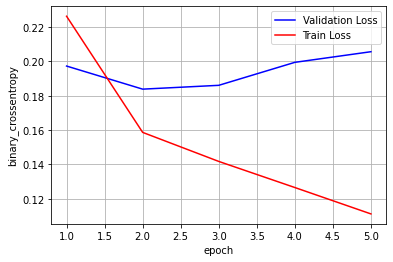

In [ ]:
#score = model.evaluate(X_test, Y_test, verbose=0) 
#print('Test score:', score[0]) 
#print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary_crossentropy')

# list of epoch numbers
x = list(range(1,EPOCHS+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [ ]:
# evaluate model with test set
#model.save(COLAB_FILEPATH+'data/LSTM-1layer.h5')
model_lstm_1layer = keras.models.load_model(COLAB_FILEPATH+'data/LSTM-1layer.h5')

# accuracy on test data
score_1layer = model_lstm_1layer.evaluate(X_test,Y_test, verbose=0)
print('Test loss:', score_1layer[0]) 
print('Test accuracy:', score_1layer[1])

Test loss: 0.20992691814899445
Test accuracy: 0.9292618632316589


### Two LSTM layer

In [ ]:
vocab_size = len(vocabulary)
embedding_vecor_length = 32
EPOCHS = 5

model = Sequential()
model.add(Embedding(vocab_size+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(128,return_sequences=True, dropout=0.4, recurrent_dropout=0.4))
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 32)           4184256   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 128)          82432     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 4,398,401
Trainable params: 4,398,401
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks_list=[ModelCheckpoint(filepath=COLAB_FILEPATH+'data/LSTM-2layer.h5',save_best_only=True,verbose=1,)]
#Fitting the data to the model
history = model.fit(X_train, 
                    Y_train, 
                    epochs=EPOCHS, 
                    batch_size=512,
                    verbose=1,
                    #validation_data=(X_test, Y_test),
                    validation_split=0.2,
                    callbacks=callbacks_list)

Epoch 1/5
568/568 [==============================] - 366s 635ms/step - loss: 0.2914 - accuracy: 0.8889 - val_loss: 0.1939 - val_accuracy: 0.9254

Epoch 00001: val_loss improved from inf to 0.19395, saving model to ./drive/My Drive/4034-amazon-review-classification-new/data/LSTM-2layer.h5
Epoch 2/5
568/568 [==============================] - 361s 635ms/step - loss: 0.1647 - accuracy: 0.9370 - val_loss: 0.1855 - val_accuracy: 0.9282

Epoch 00002: val_loss improved from 0.19395 to 0.18551, saving model to ./drive/My Drive/4034-amazon-review-classification-new/data/LSTM-2layer.h5
Epoch 3/5
568/568 [==============================] - 361s 636ms/step - loss: 0.1428 - accuracy: 0.9461 - val_loss: 0.1804 - val_accuracy: 0.9287

Epoch 00003: val_loss improved from 0.18551 to 0.18036, saving model to ./drive/My Drive/4034-amazon-review-classification-new/data/LSTM-2layer.h5
Epoch 4/5
568/568 [==============================] - 361s 636ms/step - loss: 0.1267 - accuracy: 0.9524 - val_loss: 0.1892 - v

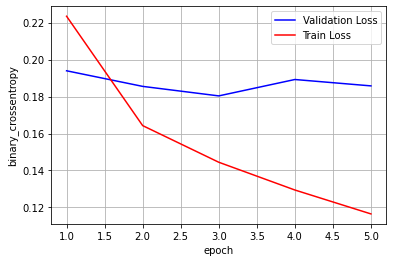

In [ ]:
#score = model.evaluate(X_test, Y_test, verbose=0) 
#print('Test score:', score[0]) 
#print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary_crossentropy')

# list of epoch numbers
x = list(range(1,EPOCHS+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [ ]:
# evaluate model with test set
#model.save(COLAB_FILEPATH+'data/LSTM-2layer.h5')
model_lstm_2layer = keras.models.load_model(COLAB_FILEPATH+'data/LSTM-2layer.h5')

# accuracy on test data
score_2layer = model_lstm_2layer.evaluate(X_test,Y_test, verbose=0)
print('Test loss:', score_2layer[0]) 
print('Test accuracy:', score_2layer[1])

Test loss: 0.21298207342624664
Test accuracy: 0.926922082901001
